In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
# pour optimisation
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from scipy.linalg import cholesky
from scipy import stats
from scipy.optimize import shgo,dual_annealing,basinhopping


plt.rcParams["figure.figsize"] = (20,8)


# Données relatives aux nouveaux cas positifs dans l'Eure (27)

In [37]:
file = "data.csv"
data = pd.read_csv(file, sep=";", parse_dates=[
                    'jour'], date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

data = data[data.cl_age90 == 0]
data = data[data.dep == "27"]
print(data)

N = data["pop"].iloc[0]
print(N)


C:\Users\LMAC_visiteurs\AppData\Local\Programs\Conda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
       dep       jour   P     T  cl_age90       pop
110560  27 2020-05-13   8   153         0  600687.0
110571  27 2020-05-14   5   175         0  600687.0
110582  27 2020-05-15   3   230         0  600687.0
110593  27 2020-05-16   0    53         0  600687.0
110604  27 2020-05-17   1    38         0  600687.0
...     ..        ...  ..   ...       ...       ...
114927  27 2021-06-14  37  2598         0  600687.0
114938  27 2021-06-15  17  2309         0  600687.0
114949  27 2021-06-16  13  1347         0  600687.0
114960  27 2021-06-17  22  2304         0  600687.0
114971  27 2021-06-18  19  2716         0  600687.0

[402 rows x 6 columns]
600687.0


          jour          P
0   2020-05-13   8.000000
1   2020-05-14   6.500000
2   2020-05-15   5.333333
3   2020-05-16   4.000000
4   2020-05-17   3.400000
..         ...        ...
397 2021-06-14  27.857143
398 2021-06-15  22.571429
399 2021-06-16  20.285714
400 2021-06-17  20.000000
401 2021-06-18  17.571429

[402 rows x 2 columns]


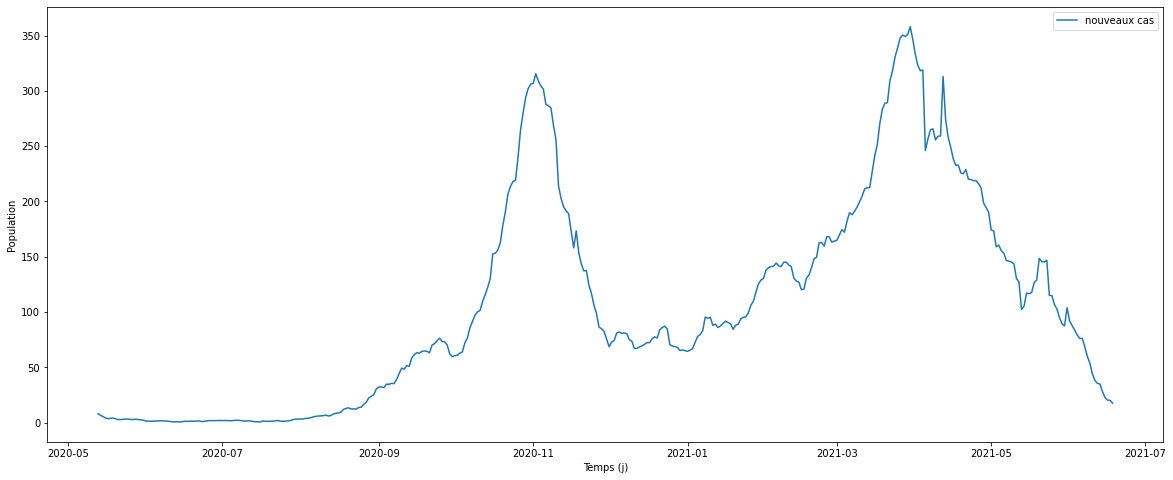

In [38]:
# moyenne sur semaine glissante, 

data.P = data.P.rolling(7, min_periods=1).mean()

I = data[["jour", "P"]]
I = I.reset_index(drop=True)
print(I)
plt.plot(data['jour'],data['P'],label='nouveaux cas')
plt.xlabel("Temps (j)")
plt.ylabel("Population")
plt.legend()
plt.show()



# Données relatives aux décès dans l'Eure (27)

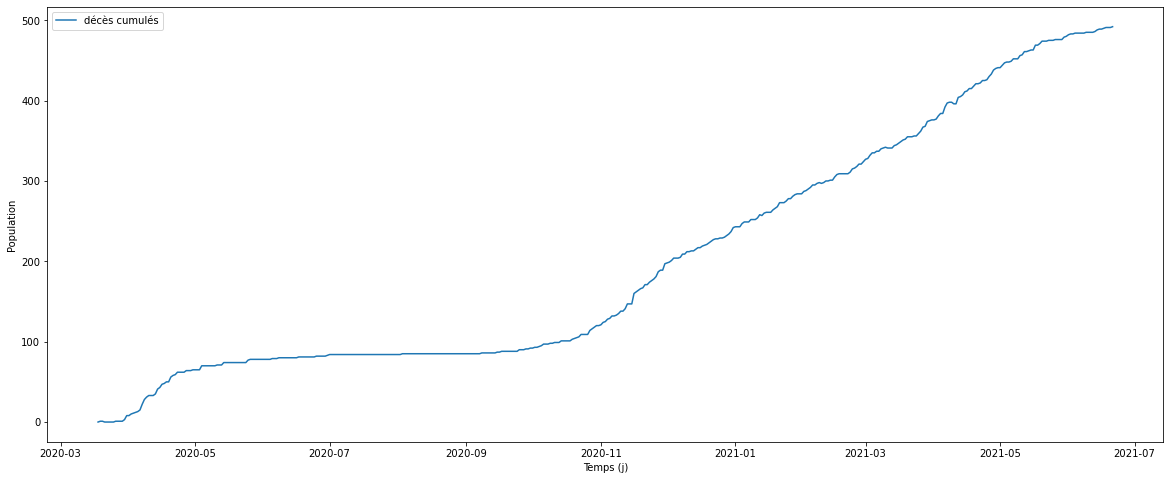

In [39]:
file = "data_hsp.csv"
data = pd.read_csv(file, sep=";", parse_dates=[
                    'jour'], date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
data = data[(data.sexe == 0) & (data.dep == "27")]
data = data[["jour","dc"]]
dc = data.reset_index(drop=True)
plt.plot(data.jour,data.dc,label='décès cumulés')
plt.xlabel("Temps (j)")
plt.ylabel("Population")
plt.legend()
dc['dc_diff'] = dc['dc'].diff()





## Fusion des dc + guéris

In [40]:
dc = dc[dc.jour >= I.jour.iloc[0]]
dc = dc[dc.jour <= I.jour.iloc[-1]]
dc = dc.reset_index(drop=True)
dc = dc.drop(columns="jour")
fusion = pd.concat([I,dc],axis=1)

first = fusion.dc.iloc[0]

print(fusion)
print(first)

          jour          P   dc  dc_diff
0   2020-05-13   8.000000   71      0.0
1   2020-05-14   6.500000   74      3.0
2   2020-05-15   5.333333   74      0.0
3   2020-05-16   4.000000   74      0.0
4   2020-05-17   3.400000   74      0.0
..         ...        ...  ...      ...
397 2021-06-14  27.857143  488      2.0
398 2021-06-15  22.571429  489      1.0
399 2021-06-16  20.285714  489      0.0
400 2021-06-17  20.000000  490      1.0
401 2021-06-18  17.571429  491      1.0

[402 rows x 4 columns]
71


# Calcul du nombre de guéris

In [41]:
    # =====================================================================
    #                   Estimation nombre de guéris
    # =====================================================================

    """
    Principe : 

    On prend le nombre de mort le jour t, puis on regarde le nombre d'infectés a t-delta t
    et on calcul le nombre de guéris comme étant : G(t) = Infecté(t-delta t) - Mort(t)
    Par la suite, on prend la somme cumulée du nombre de guéris car un guéris 
    est supposé immunisé et ne pourra plus être susceptible
    """
    # loi normal pour lee temps de guérison

    mu, sigma = 10, np.sqrt(5)

    G = []

    for jours in fusion.jour:
        # aspect aléatoire dans la guérison
        delta_t = 10
        delta = datetime.timedelta(delta_t)
        deltajour = jours - delta
        deltajour = datetime.datetime.strftime(deltajour, '%Y-%m-%d')

        mort_t = fusion[fusion.jour == jours]['dc_diff'].item()
        if not fusion[fusion.jour == deltajour]['P'].tolist():
            gueri_t = 0
        else:

            infected_t_10 = fusion.loc[fusion['jour'] ==
                                   deltajour]['P'].item()
            gueri_t = infected_t_10 - mort_t

        G.append({'jour': jours, 'G': gueri_t})

    G = pd.DataFrame(G)
    G['G_cumul'] = G['G'].cumsum()
    G = G.drop('jour', axis=1)
    SIR_ = pd.concat([fusion, G], axis=1)
dc_min = SIR_.dc.iloc[0]
SIR_.loc[:,"dc"] = SIR_.dc.apply(lambda x: x - dc_min)
SIR_['P_cumul'] = SIR_.P.cumsum()
print(SIR_)

          jour          P   dc  dc_diff          G       G_cumul       P_cumul
0   2020-05-13   8.000000    0      0.0   0.000000      0.000000      8.000000
1   2020-05-14   6.500000    3      3.0   0.000000      0.000000     14.500000
2   2020-05-15   5.333333    3      0.0   0.000000      0.000000     19.833333
3   2020-05-16   4.000000    3      0.0   0.000000      0.000000     23.833333
4   2020-05-17   3.400000    3      0.0   0.000000      0.000000     27.233333
..         ...        ...  ...      ...        ...           ...           ...
397 2021-06-14  27.857143  417      2.0  77.285714  41352.780952  42281.638095
398 2021-06-15  22.571429  418      1.0  75.000000  41427.780952  42304.209524
399 2021-06-16  20.285714  418      0.0  76.142857  41503.923810  42324.495238
400 2021-06-17  20.000000  419      1.0  67.571429  41571.495238  42344.495238
401 2021-06-18  17.571429  420      1.0  59.000000  41630.495238  42362.066667

[402 rows x 7 columns]


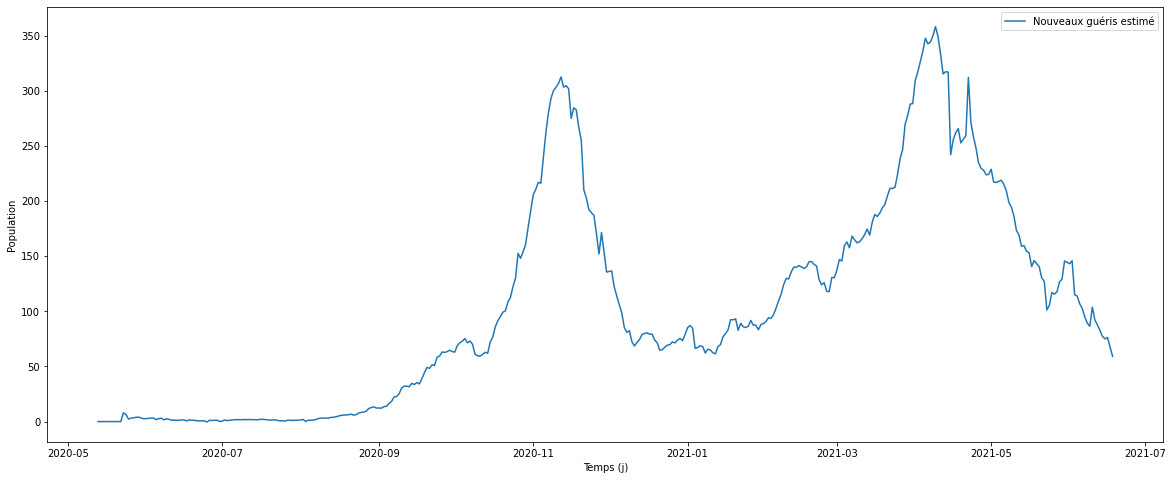

In [42]:
plt.plot(SIR_.jour,SIR_.G,label='Nouveaux guéris estimé')
plt.xlabel("Temps (j)")
plt.ylabel("Population")
plt.legend()


In [43]:
data = pd.DataFrame()
data['D'] = SIR_['dc'] / N 
data['R'] = SIR_['G_cumul'] / N
data['I'] = SIR_['P_cumul'] / N - data['R'] - data['D']
data['S'] = 1 - data['I'] - data['R'] - data['D']
data['jour'] = SIR_['jour']
data = data[data.columns[::-1]]
start = datetime.datetime(2020,7,1)
stop =  datetime.datetime(2021,5,1)
period = (data["jour"] >= start)  & (data["jour"] <= stop)
data = data[period]
data = data.reset_index(drop=True)

print(data,N)


          jour         S         I         R         D
0   2020-07-01  0.999822  0.000020  0.000136  0.000022
1   2020-07-02  0.999819  0.000021  0.000138  0.000022
2   2020-07-03  0.999816  0.000023  0.000140  0.000022
3   2020-07-04  0.999813  0.000024  0.000142  0.000022
4   2020-07-05  0.999811  0.000024  0.000144  0.000022
..         ...       ...       ...       ...       ...
300 2021-04-27  0.938719  0.003689  0.056989  0.000603
301 2021-04-28  0.938388  0.003632  0.057369  0.000611
302 2021-04-29  0.938064  0.003580  0.057741  0.000614
303 2021-04-30  0.937748  0.003522  0.058115  0.000616
304 2021-05-01  0.937457  0.003431  0.058496  0.000616

[305 rows x 5 columns] 600687.0


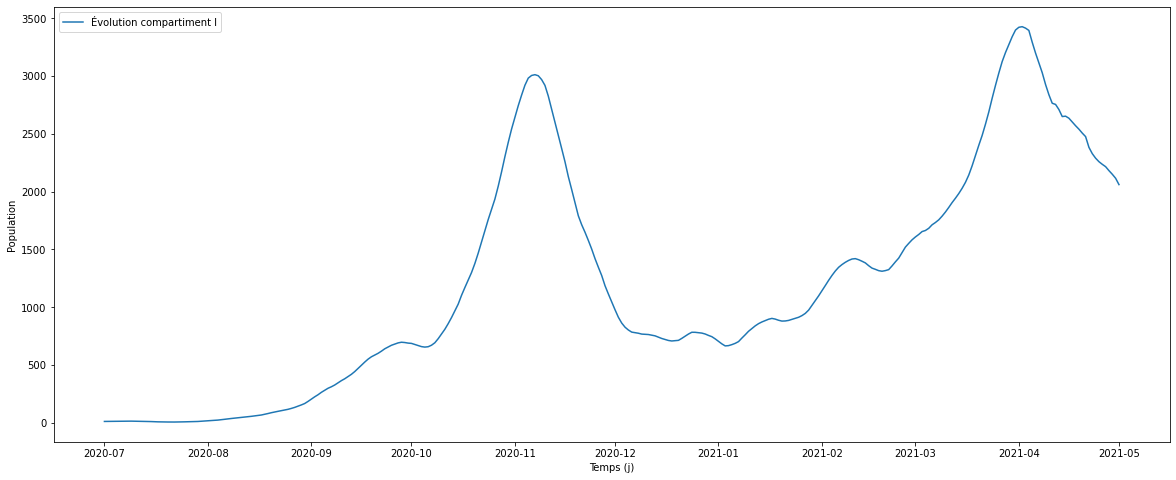

In [44]:
plt.plot(data.jour,data.I*N,label='Évolution compartiment I')
plt.xlabel("Temps (j)")
plt.ylabel("Population")
plt.legend()

# Augmentation des données via fit déterministe


In [48]:
from models.SIRD import SIRD
sird = SIRD()
# set N
sird.setParam({'N':N})
# fitting données déterministes
sird.fit(data)
sird.pplot('gamma','beta')

X0 = data.iloc[-1][['S','I','R','D']].to_numpy()*N
beta = sird.fitted.iloc[-1]['beta']
gamma = sird.fitted.iloc[-1]['gamma']
nu = sird.fitted.iloc[-1]['nu']
dt = 0.01
T = 1

n = int(T/dt)
sird.setParam(
    {
        'beta':beta,
        'gamma':gamma
        'nu' : nu
    }
)
t = np.linspace(0,T,n)
sird.simulate(X0,t,dt,nsim=150,type_simulation='stochastique')


Fitting data from : 2020-07-01 00:00:00 to 2021-05-01 00:00:00
Utilisez plt.show() pour afficher le graphique
Integration d'un modèle SIRD stochastique...
 Nombre de simulation : 150
 Durée de la simulation T = 1.0 jours
 Pas de temps dt = 0.01
 Paramètres :
   N  :  600687.0
   beta  :  0
   gamma  :  0
   nu  :  0
 Vecteur initial X0 = [563118.5047619047 2061.0000000000073 35137.49523809524 370.0]


LinAlgError: 1-th leading minor of the array is not positive definite

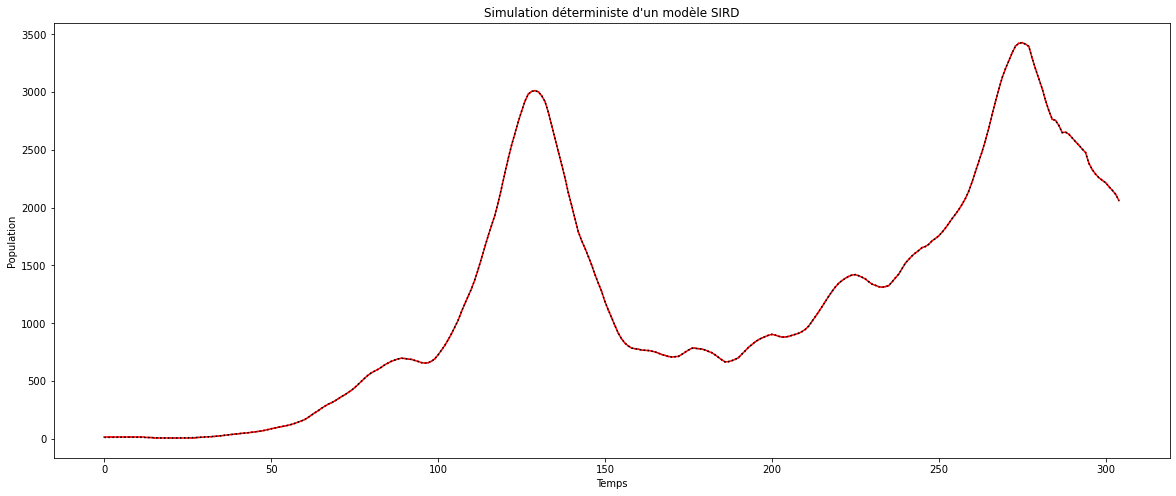

In [31]:
# resimulation de la courbe à partir des données
augmented_data = []
# pour chaque jour tracer entre deux jours
for i in range(len(data)-1):
    
    X0 = np.array([data.iloc[i].S,data.iloc[i].I,data.iloc[i].R,data.iloc[i].D])
    X0 = X0 * N
    augmented_data.append(X0)
    t = np.linspace(i,i+1,1000)
    dt = 0.001
    sird.setParam(
        {
            'beta': sird.fitted.iloc[i].beta,
            'gamma': sird.fitted.iloc[i].gamma,
            'nu': sird.fitted.iloc[i].nu 
        }
    )
    sird.simulate(X0,t,dt,type_simulation="deterministe",show_details=False)
    for sim in sird.sol_deter:
        augmented_data.append(sim)
    sird.mplot(compartiment=1,det=True,label=False)
plt.plot(data.index,data.I*N,color='k',ls='dotted')
plt.show()

In [32]:
augmented_data = np.array(augmented_data)
print(len(augmented_data))

304304


In [33]:
chunks = np.split(augmented_data[:,0:-1],304)
print(chunks[0])

[[6.00580076e+05 1.22857143e+01 8.16380952e+01]
 [6.00580076e+05 1.22857143e+01 8.16380952e+01]
 [6.00580074e+05 1.22861284e+01 8.16394757e+01]
 ...
 [6.00578257e+05 1.27056091e+01 8.30377349e+01]
 [6.00578255e+05 1.27060373e+01 8.30391625e+01]
 [6.00578253e+05 1.27064656e+01 8.30405901e+01]]


In [34]:
def drift(X,params):
    beta,gamma,nu = params
    if X[1] <= 0:
        return np.zeros(len(X))
    else :
        return np.array([
                -beta*X[0]*X[1]/N,
                (beta*X[0]*X[1]/N)-gamma*X[1] - nu*X[1],
                gamma*X[1]
            ])

def diffusion(X,params):
    beta,gamma,nu = params
    if X[1] <= 0:
        return np.zeros((len(X),len(X)))

    a = np.array([
        [beta*X[0]*X[1]/N, -beta*X[0]*X[1]/N, 0],
        [-beta*X[0]*X[1]/N, (beta*X[0]*X[1]/N) + gamma *
            X[1] + nu*X[1], -gamma*X[1]],
        [0, -gamma*X[1], gamma*X[1]]
    ])
    return a



def log_likelihood(params,data):
    if np.isnan(params).any():
        params = [0.1,0.1,0.1]
    sum = 0
    for i in range(0,len(data[:,0])-1):
        mean = data[i,:] + dt*drift(data[i,:],params)
        var = dt*diffusion(data[i,:],params)
        if np.all(var==0):
            sum+= 0
        else :
            sum += np.log(multivariate_normal.pdf(data[i+1,:],mean=mean,cov=var))
    # print("####################")
    # print("parameter :",params)
    # print("log-L :", sum)
    # print("####################")

    return -sum


In [35]:

params = []

bounds = ((1e-5,0.99),(1e-5,0.99),(1e-5,0.99))
# 'L-BFGS-
for i,chunk in enumerate(chunks) :
    params0 = [sird.fitted.iloc[i].beta, sird.fitted.iloc[i].gamma, sird.fitted.iloc[i].nu]
    minimizer_kwargs = {
    "args": (chunk),
    "bounds" : bounds,
    "method": 'L-BFGS-B'
    }
    res = minimize(
    log_likelihood,
        params0,
        args=(chunk),
        method='L-BFGS-B',
        bounds=bounds
    )
    print("Itération {}/{} : ".format(i+1,len(chunks)), "Stochastique : ", res.x, " || Différence stoch. vs deter. : ", params0-res.x)
    params.append(res.x)


KeyboardInterrupt: 

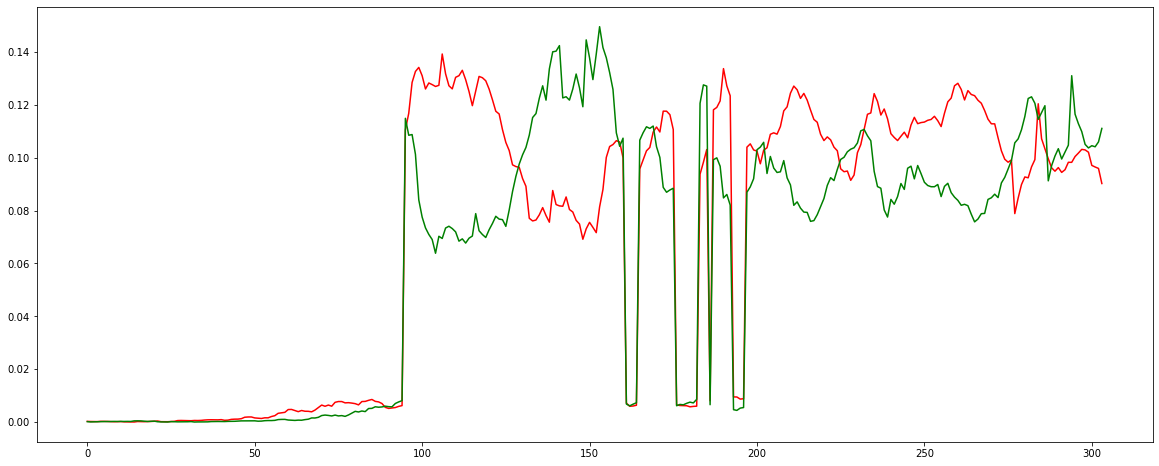

In [17]:
params = np.array(params)
plt.plot([i for i in range(len(params[:,0]))], params[:,0],color='r')
plt.plot([i for i in range(len(params[:,0]))], params[:,1],color='g')


Utilisez plt.show() pour afficher le graphique


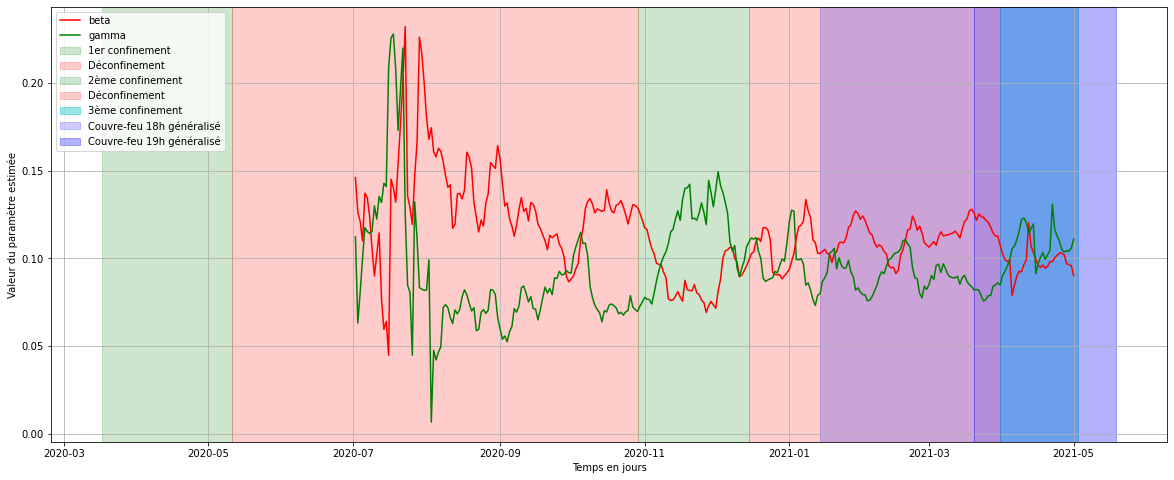

In [17]:
sird.pplot("beta","gamma")


(array([ 54.,  16.,  77., 108.,  15.,   9.,  11.,   5.,   0.,   3.,   2.,
          0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   2.]),
 array([1.00000000e-05, 3.11151914e-02, 6.22203829e-02, 9.33255743e-02,
        1.24430766e-01, 1.55535957e-01, 1.86641149e-01, 2.17746340e-01,
        2.48851532e-01, 2.79956723e-01, 3.11061914e-01, 3.42167106e-01,
        3.73272297e-01, 4.04377489e-01, 4.35482680e-01, 4.66587872e-01,
        4.97693063e-01, 5.28798255e-01, 5.59903446e-01, 5.91008637e-01,
        6.22113829e-01]),
 <BarContainer object of 20 artists>)

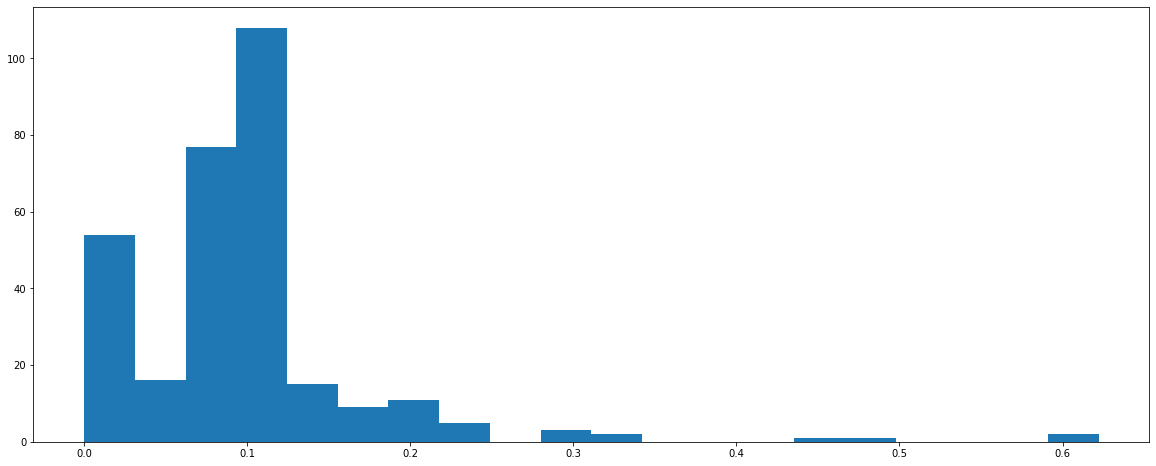

In [18]:
plt.hist(params[:,0],bins=20)

In [ ]:
# dtmc estimation. 

print(data)